In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
import os
import sys
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.optimize import minimize
SEED = 42
def feval(pred_proba, dtrain):
    y_true = dtrain.get_label().astype(int)
    roc = roc_auc_score(y_true, pred_proba)
    return "roc", roc

In [2]:
test = pd.read_csv("../input/jpeg-melanoma-256x256/test.csv")
train = pd.read_csv("../input/jpeg-melanoma-256x256/train.csv")
print(train.shape, test.shape)
print(test.columns)
print(train.columns)


(33126, 11) (10982, 7)
Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'width', 'height'],
      dtype='object')
Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'tfrecord', 'width', 'height'],
      dtype='object')


In [24]:
kernel_dir =  "../exp/kernel"
kernel_names = ["_pt", "_meta"]
oof_list = [os.path.join(kernel_dir, f"oof{fname}.csv") for fname in kernel_names]
sub_list = [os.path.join(kernel_dir, f"submission{fname}.csv") for fname in kernel_names]
futter = ["_TTA1", "_TTA5"]
No_list = [0, 1, 2]
fig_size_list = [256, 384, 512, 768]
for fut in futter:
    for fig_size in fig_size_list:
        for No in No_list:
            dir_path = f"../exp/{fig_size}-{No}"
            oof_path = os.path.join(dir_path, f"oof_No{No}_{fig_size}{fut}.csv")
            if os.path.isfile(oof_path):
                oof_list.append(oof_path)
            sub_path = os.path.join(dir_path, f"submission_No{No}_{fig_size}{fut}.csv")
            if os.path.isfile(sub_path):
                sub_list.append(sub_path)
print(len(oof_list), len(sub_list))

19 19


In [25]:
oof_cols = [f"oof_{i}" for i in range(len(oof_list))]
oof_df = pd.DataFrame(np.zeros((len(train), len(oof_list))), columns=oof_cols)
pred_cols = [f"pred_{i}" for i in range(len(oof_list))]
pred_df = pd.DataFrame(np.zeros((len(test), len(sub_list))), columns=pred_cols)
for i in range(len(oof_list)):
    
    oof_df.iloc[:, i] = pd.read_csv(oof_list[i]).reset_index()["0"]
    pred_df.iloc[:, i] = pd.read_csv(sub_list[i]).reset_index()["target"]
    roc = roc_auc_score(train["target"].values, oof_df.iloc[:, i].values)
    print(f"{oof_list[i].split('/')[-1]}, roc:{roc:.5f}")
roc = roc_auc_score(train["target"].values, oof_df.mean(axis=1).values)
print(f"avg, roc:{roc:.5f}")
print(oof_df.shape, pred_df.shape)
sub = pd.read_csv(f"../input/jpeg-melanoma-{fig_size}x{fig_size}/sample_submission.csv")
sub["target"] = pred_df.mean(axis=1).values
sub.to_csv(f"../exp/ensemble/submission_avg.csv", index=False)
sub

oof_pt.csv, roc:0.88473
oof_meta.csv, roc:0.82907
oof_No0_256_TTA1.csv, roc:0.87891
oof_No1_256_TTA1.csv, roc:0.87277
oof_No2_256_TTA1.csv, roc:0.89128
oof_No0_384_TTA1.csv, roc:0.89989
oof_No1_384_TTA1.csv, roc:0.87027
oof_No2_384_TTA1.csv, roc:0.86789
oof_No1_512_TTA1.csv, roc:0.87592
oof_No2_512_TTA1.csv, roc:0.88975
oof_No0_768_TTA1.csv, roc:0.84800
oof_No2_768_TTA1.csv, roc:0.86828
oof_No0_256_TTA5.csv, roc:0.88224
oof_No1_256_TTA5.csv, roc:0.88373
oof_No2_256_TTA5.csv, roc:0.89128
oof_No0_384_TTA5.csv, roc:0.90034
oof_No1_384_TTA5.csv, roc:0.87241
oof_No1_512_TTA5.csv, roc:0.87557
oof_No0_768_TTA5.csv, roc:0.84503
avg, roc:0.90850
(33126, 19) (10982, 19)


,image_name,target
0,ISIC_0052060,0.001201
1,ISIC_0052349,0.000433
2,ISIC_0058510,0.000123
3,ISIC_0073313,0.000130
4,ISIC_0073502,0.009888
...,...,...
10977,ISIC_9992485,0.003171
10978,ISIC_9996992,0.009462
10979,ISIC_9997917,0.035105
10980,ISIC_9998234,0.000813


In [26]:
Y_values = train["target"].values
predictions = []
lls = []
wghts = []
# Define the objective function to optimize MSE by using ScyiPy algorithm.
def roc_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
        final_prediction += weight*prediction

    return 1.0 - roc_auc_score(Y_values, final_prediction)



In [27]:
# Optimization runs 100 times.
_weights = []

skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
for i, (train_idx, val_idx) in enumerate(skf.split(oof_df.values, train["target"].values)):
    X_train = oof_df.loc[train_idx].values
    X_val = oof_df.loc[val_idx].values
    y_train = train.loc[train_idx, "target"].values
    y_val = train.loc[val_idx, "target"].values
    predictions = []
    lls = []
    wghts = []
    for j in range(oof_df.shape[1]):
        predictions.append(np.array(oof_df.iloc[train_idx, j]))
    Y_values = train.loc[train_idx, "target"].values

    def roc_func(weights):
        ''' scipy minimize will pass the weights as a numpy array '''
        final_prediction = 0
        for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction
        return 1.0 - roc_auc_score(Y_values, final_prediction)
    
    for i in range(100):
        starting_values = np.random.uniform(size=oof_df.shape[1])
        # cons are given as constraints.
        cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
        bounds = [(0,1)]*oof_df.shape[1]
        
        res = minimize(roc_func, starting_values, constraints=cons,
                    bounds = bounds, method='SLSQP')
        lls.append(res['fun'])
        wghts.append(res['x'])
    bestSC = np.min(lls)
    bestWght = wghts[np.argmin(lls)]
    _weights.append(bestWght)
    print('Best Weights: {weights:}'.format(weights=bestWght))
    print('Train Ensemble ROC: {:.7f}'.format(roc_auc_score(y_train, np.sum(bestWght * X_train, axis=1))))
    print('Val   Ensemble ROC: {:.7f}'.format(roc_auc_score(y_val, np.sum(bestWght * X_val, axis=1))))

    

Best Weights: [1.83978620e-01 1.11022302e-15 5.51971617e-02 1.11022302e-16
 1.95055388e-01 4.06736688e-02 0.00000000e+00 2.22044605e-16
 2.22044605e-16 2.27840303e-02 4.44089210e-16 5.55111512e-17
 0.00000000e+00 2.43737432e-01 2.58573699e-01 0.00000000e+00
 1.11022302e-16 1.11022302e-16 0.00000000e+00]
Train Ensemble ROC: 0.9128017
Val   Ensemble ROC: 0.9193228
Best Weights: [2.89194371e-04 8.31848146e-16 2.62115495e-01 1.52110103e-01
 5.87695879e-02 3.42475213e-01 0.00000000e+00 4.09561327e-20
 4.77821548e-20 1.66417411e-16 4.09561327e-20 0.00000000e+00
 4.09561327e-20 1.84240407e-01 1.36520442e-20 2.77555756e-17
 4.15958203e-16 0.00000000e+00 2.77350975e-17]
Train Ensemble ROC: 0.9130797
Val   Ensemble ROC: 0.9081749
Best Weights: [2.06655755e-04 1.27836222e-04 7.19443735e-03 6.73421741e-18
 9.83598980e-18 2.13469833e-01 2.55106703e-16 7.23324786e-18
 1.87705973e-02 1.30374818e-17 4.70455041e-04 5.94430024e-18
 1.06589267e-17 2.89007486e-01 2.79810936e-01 1.90456991e-01
 8.10296691e

In [28]:
pred = np.sum(np.array(_weights).mean(axis=0)*oof_df.values, axis=1)
roc = roc_auc_score(train["target"].values, pred)
print("ROC", roc)
y_test = np.sum(np.array(_weights).mean(axis=0)*pred_df.values, axis=1)
sub["target"] = y_test
sub.to_csv(f"../exp/ensemble/submission_meta.csv", index=False)
sub

ROC 0.9173825311525758


,image_name,target
0,ISIC_0052060,0.000532
1,ISIC_0052349,0.000088
2,ISIC_0058510,0.000034
3,ISIC_0073313,0.000058
4,ISIC_0073502,0.004344
...,...,...
10977,ISIC_9992485,0.002171
10978,ISIC_9996992,0.007019
10979,ISIC_9997917,0.023413
10980,ISIC_9998234,0.000308


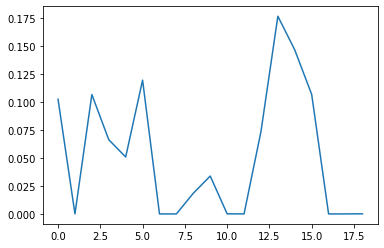

In [29]:
plt.plot(np.array(_weights).mean(axis=0))

In [30]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

In [31]:
oof_df

,oof_0,oof_1,oof_2,oof_3,oof_4,oof_5,oof_6,oof_7,oof_8,oof_9,oof_10,oof_11,oof_12,oof_13,oof_14,oof_15,oof_16,oof_17,oof_18
0,0.000026,0.001699,0.002124,0.000030,0.000515,0.001566,0.000105,0.000431,0.001633,5.306615e-06,0.000860,0.000909,0.005325,0.000027,0.000515,0.001664,0.000196,0.001444,0.001568
1,0.000006,0.001993,0.000010,0.000005,0.000011,0.000013,0.000156,0.000020,0.001313,7.774176e-07,0.000092,0.000003,0.000005,0.000003,0.000011,0.000012,0.000206,0.000412,0.000099
2,0.001111,0.009177,0.001158,0.000587,0.000719,0.000073,0.000354,0.000499,0.000329,5.410254e-05,0.001146,0.000679,0.000124,0.000667,0.000719,0.000038,0.000193,0.000295,0.000848
3,0.001381,0.015521,0.009599,0.000159,0.001848,0.017577,0.011912,0.005438,0.008604,3.041047e-03,0.307041,0.026362,0.010180,0.000119,0.001848,0.033756,0.024291,0.005189,0.272957
4,0.000076,0.002558,0.000019,0.000004,0.000015,0.000021,0.000130,0.000017,0.001376,9.875233e-06,0.000058,0.000032,0.000010,0.000011,0.000015,0.000017,0.000446,0.000803,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33121,0.047813,0.082185,0.001858,0.007276,0.015909,0.010486,0.028262,0.014210,0.005086,2.738641e-02,0.016678,0.045471,0.009045,0.076949,0.015909,0.048856,0.035465,0.018033,0.015364
33122,0.000644,0.001987,0.000121,0.000013,0.000077,0.000860,0.000181,0.000041,0.001021,3.689372e-06,0.000119,0.000764,0.000113,0.000025,0.000077,0.000050,0.000156,0.001144,0.000119
33123,0.000083,0.014290,0.001833,0.001478,0.000091,0.000055,0.012087,0.004936,0.004770,1.730520e-03,0.007082,0.008196,0.004869,0.002866,0.000091,0.000127,0.014588,0.004325,0.007451
33124,0.016259,0.012460,0.006414,0.002274,0.002540,0.010095,0.039309,0.029844,0.037565,1.354536e-02,0.059633,0.010096,0.017724,0.019234,0.002540,0.018588,0.030611,0.034499,0.059446


In [32]:
test = pd.read_csv("../input/jpeg-melanoma-256x256/test.csv")
train = pd.read_csv("../input/jpeg-melanoma-256x256/train.csv")
y = train.target
cols = test.columns
train = train.loc[:, cols]

In [33]:
train.columns = ['img_name', "pid", 'sex', 'age', 'location','width','height']
test.columns = ['img_name', "pid", 'sex', 'age', 'location','width','height']
#creating dummy variables for categorical sex data

sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)

train.drop(['sex'], axis=1, inplace=True)
test.drop(['sex'], axis=1, inplace=True)
train.drop(['pid'], axis=1, inplace=True)
test.drop(['pid'], axis=1, inplace=True)
# getting dummy variables for location on train set

anatom_dummies = pd.get_dummies(train['location'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)

# getting dummy variables for location on test set

anatom_dummies = pd.get_dummies(test['location'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)

# dropping useless columns
train.drop('location', axis=1, inplace=True)
test.drop(['location'], axis=1, inplace=True)
for df in [train, test]:
    df.drop('img_name', axis=1, inplace=True)
X = pd.concat([train, oof_df], axis=1)
test = pd.concat([test, pred_df], axis=1)



In [34]:
# taking 15% of the training data as holdou
cv = StratifiedKFold(5, shuffle=True, random_state=42)
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...

xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=3,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,
    n_jobs=-1,
)

In [35]:
estimators = [xg]
def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train roc Mean'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Test roc Mean'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test roc Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

In [36]:

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models.style.background_gradient(cmap='twilight', axis=1))

,Model Name,Train roc Mean,Test roc Mean,Test Std,Time
0,XGBClassifier,0.980335,0.923143,0.010402,11.651225


In [37]:
X.columns

Index(['age', 'width', 'height', 'sex_female', 'sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity', 'oof_0', 'oof_1', 'oof_2',
       'oof_3', 'oof_4', 'oof_5', 'oof_6', 'oof_7', 'oof_8', 'oof_9', 'oof_10',
       'oof_11', 'oof_12', 'oof_13', 'oof_14', 'oof_15', 'oof_16', 'oof_17',
       'oof_18'],
      dtype='object')

In [38]:
test.columns

Index(['age', 'width', 'height', 'sex_female', 'sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity', 'pred_0', 'pred_1', 'pred_2',
       'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9',
       'pred_10', 'pred_11', 'pred_12', 'pred_13', 'pred_14', 'pred_15',
       'pred_16', 'pred_17', 'pred_18'],
      dtype='object')

In [39]:
# fitting train data
# setup dataloader
oof = np.zeros((len(train), 1))  # Out Of Fold predictions
preds = np.zeros((len(test), 5))

skf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (idxT, idxV) in enumerate(skf.split(X, y)):
    X_train = X.iloc[idxT].values
    y_train = y[idxT].values
    X_val = X.iloc[idxV].values
    y_val = y[idxV].values
    xg.fit(X_train, y_train)
    # predicting on holdout set
    oof[idxV] = xg.predict_proba(X_val)[:, 1].reshape(-1, 1)
    preds[:, fold] = xg.predict_proba(test.values)[:, 1]

0.922428460206957


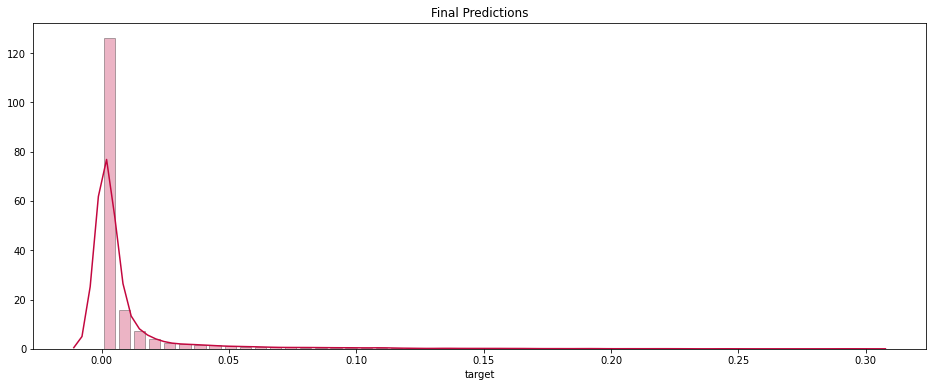

In [40]:
print(roc_auc_score(y, oof.reshape(-1)))
pd.Series(oof.reshape(-1,)).to_csv("../exp/kernel/oof_meta1.csv", index=False)
# display auc distribution
sub = pd.read_csv(f"../input/jpeg-melanoma-256x256/sample_submission.csv")
sub["target"] = preds.mean(axis=1)
sub.to_csv('../exp/ensemble/submission_meta1.csv', index=False)
fig, ax = plt.subplots(figsize=(16,6))
sns.distplot(sub['target'], hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             }, color='#C3073F')
ax.set_title('Final Predictions')
plt.show()

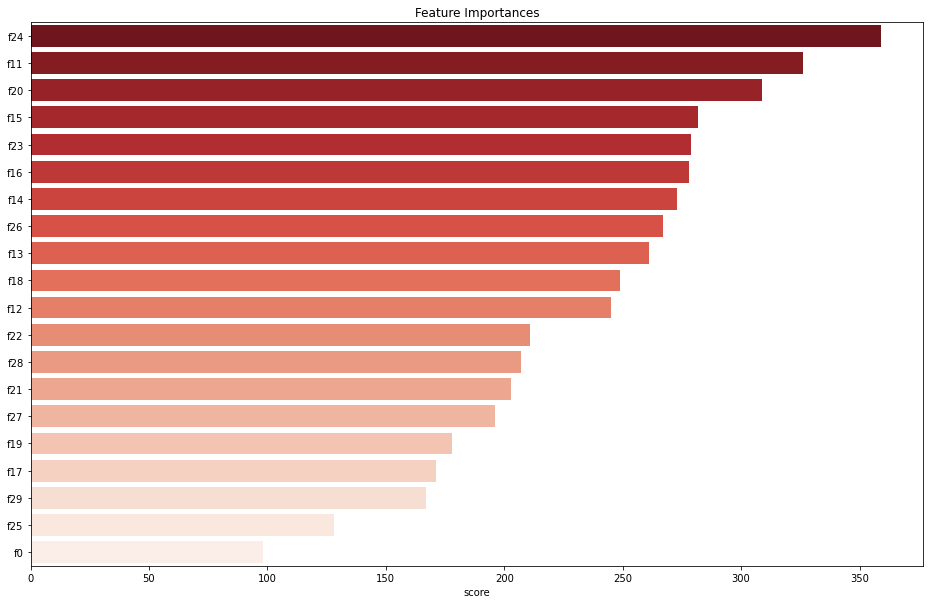

In [41]:
feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importances')
plt.show()

In [25]:
# creating adversarial training set

adv_train = train.copy()
adv_test = test.copy()

adv_train['dataset_label'] = 0
adv_test['dataset_label'] = 1

adv_master = pd.concat([adv_train, adv_test], axis=0)

adv_X = adv_master.drop('dataset_label', axis=1)
adv_y = adv_master['dataset_label']

adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(adv_X,
                                                    adv_y,
                                                    test_size=0.4,
                                                    stratify=adv_y,
                                                    random_state=42)

In [26]:
xg_adv = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
)

# Fitting train data

xg_adv.fit(adv_X_train, adv_y_train)

# Predicting on holdout set
validation = xg_adv.predict_proba(adv_X_test)[:,1]

In [31]:
def plot_roc_feat(y_trues, y_preds, labels, est, x_max=1.0):
    
    """ A function for displaying roc/auc curve and feature importances. """
    
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax[0].plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax[0].legend()
    ax[0].grid()
    ax[0].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax[0].set_title('ROC curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_xlim([-0.01, x_max])
    _ = ax[0].set_ylabel('True Positive Rate')
    
    
    feature_importance = est.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())
    importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
    
    sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
             ax=ax[1])
    ax[1].set_title('Feature Importances')

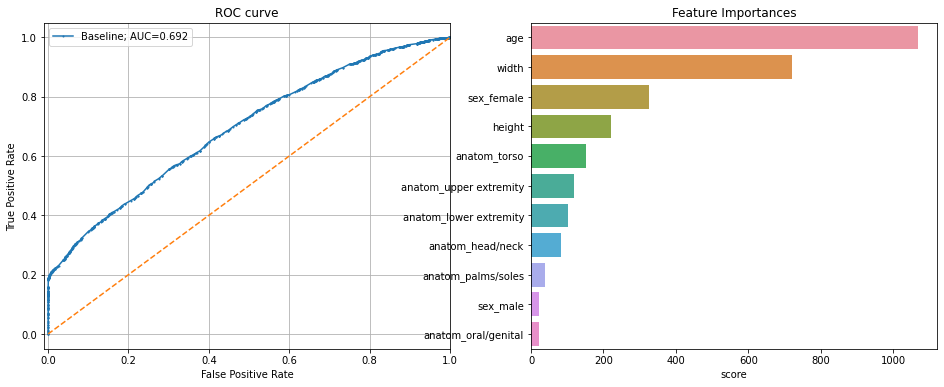

In [32]:
plot_roc_feat(
    [adv_y_test],
    [validation],
    ['Baseline'],
    xg_adv
)

In [49]:
# dark magick
# 以下はテストデータのみのサブミットをブレンドする本質的でないので注意
test = pd.read_csv("../input/jpeg-melanoma-256x256/test.csv")
train = pd.read_csv("../input/jpeg-melanoma-256x256/train.csv")
sub = pd.read_csv(f"../input/jpeg-melanoma-256x256/sample_submission.csv")

kernel_dir =  "../exp/kernel"
kernel_names = ["_en", "_log2", "_median", "_mean", "_minmax"]
_sub_list = [os.path.join(kernel_dir, f"submission{fname}.csv") for fname in kernel_names]
_pred_cols = [f"pred_{i}" for i in kernel_names]
_pred_df = pd.DataFrame(np.zeros((len(test), len(_sub_list))), columns=_pred_cols)

for i in range(len(_sub_list)):
    _pred_df.iloc[:, i] = pd.read_csv(_sub_list[i]).reset_index()["target"]
weights_ = [1./6., 1./6., 1./6., 1./6., 2./6.]
y_test = np.sum(np.array(weights_).mean(axis=0)*_pred_df.values, axis=1)
sub["target"] = y_test
next_sub = sub.copy()
one_idx = y_test > 0.1
print(one_idx.sum())
# sub.to_csv(f"../exp/ensemble/submission_dark.csv", index=False)
# sub


475


7

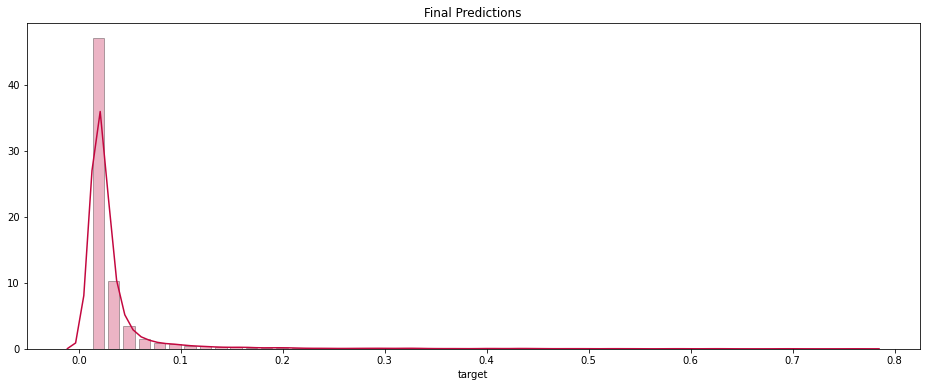

In [50]:
fig, ax = plt.subplots(figsize=(16,6))
sns.distplot(sub['target'], hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             }, color='#C3073F')
ax.set_title('Final Predictions')
plt.show()

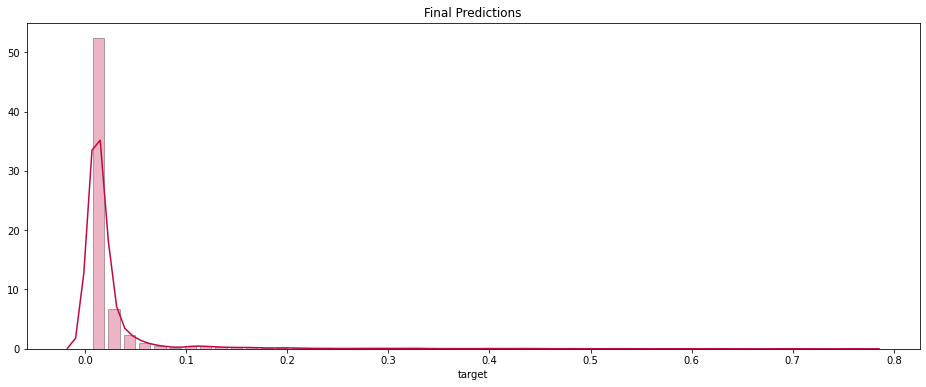

In [51]:
# todo 
# praba 0,5以上はそのままでそれ以外をアンサンブル
my_sub = pd.read_csv("../exp/ensemble/submission_meta1.csv")
tmp = my_sub["target"].values*0.5 + sub["target"].values *0.5
sub["target"] = tmp
sub.loc[one_idx, "target"] = next_sub.loc[one_idx, "target"]
sub.to_csv(f"../exp/ensemble/submission_dark_en05.csv", index=False)

fig, ax = plt.subplots(figsize=(16,6))
sns.distplot(sub['target'], hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             }, color='#C3073F')
ax.set_title('Final Predictions')
plt.show()

In [11]:
sub

,image_name,target
0,ISIC_0052060,0.010002
1,ISIC_0052349,0.007937
2,ISIC_0058510,0.009926
3,ISIC_0073313,0.008322
4,ISIC_0073502,0.013261
...,...,...
10977,ISIC_9992485,0.007618
10978,ISIC_9996992,0.016348
10979,ISIC_9997917,0.052760
10980,ISIC_9998234,0.011183
